# Fine-tune SAM on customized datasets (2D example)
1. Prepare original 2D images `data/MedSAMDemo_2D/` (Download link:https://drive.google.com/file/d/18GhVEODbTi17jSeBXdeLQ7vHPdtlTYXK/view?usp=share_link) 
2. Run `pre_grey_rgb2D.py` for pre-processing. Expected output: `./data/demo2D_vit_b/demo2d.npz`
3. Start this fine-tuning tutorial

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [72]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [73]:
# %% test dataset class and dataloader
npz_tr_path = 'data/demo2D_vit_b'
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)
img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


In [74]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/demo2D_vit_b'
work_dir = './work_dir'
task_name = 'demo2D'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True) #directory 생성
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [158]:
#%% train
num_epochs = 100
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 0, Loss: 0.11585455600704465


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 1, Loss: 0.11042679526976176


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 2, Loss: 0.10693189395325524


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


EPOCH: 3, Loss: 0.10773409051554543


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


EPOCH: 4, Loss: 0.10232586307185036


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


EPOCH: 5, Loss: 0.09821970335074834


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


EPOCH: 6, Loss: 0.1006416848727635


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 7, Loss: 0.0984463883297784


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 8, Loss: 0.09648459511143821


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 9, Loss: 0.09693187475204468


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 10, Loss: 0.10141143734966006


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


EPOCH: 11, Loss: 0.09306872423206057


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


EPOCH: 12, Loss: 0.09648195547716958


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


EPOCH: 13, Loss: 0.09185051066534859


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 14, Loss: 0.09421733447483607


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 15, Loss: 0.09324920922517776


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 16, Loss: 0.09077755255358559


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 17, Loss: 0.09173517142023359


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 18, Loss: 0.08660939655133656


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 19, Loss: 0.08580822710480009


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 20, Loss: 0.08689866321427482


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 21, Loss: 0.08689965573804719


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 22, Loss: 0.08215401428086418


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 23, Loss: 0.0835912259561675


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 24, Loss: 0.08476991632155009


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 25, Loss: 0.08407657380614962


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 26, Loss: 0.08164621357406888


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 27, Loss: 0.08395546674728394


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 28, Loss: 0.08805358409881592


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 29, Loss: 0.07943067167486463


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 30, Loss: 0.07815525680780411


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


EPOCH: 31, Loss: 0.08463884145021439


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 32, Loss: 0.08089358785322734


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 33, Loss: 0.08956835631813322


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 34, Loss: 0.0763235113450459


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 35, Loss: 0.0789349153637886


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 36, Loss: 0.07865444357906069


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 37, Loss: 0.08166512634072985


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 38, Loss: 0.07876879083258766


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 39, Loss: 0.0821310526558331


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 40, Loss: 0.07572415790387563


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 41, Loss: 0.07565341836639813


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 42, Loss: 0.07522271839635712


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 43, Loss: 0.0814342727618558


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 44, Loss: 0.07729497711573328


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 45, Loss: 0.07772443230663027


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 46, Loss: 0.07798990075077329


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 47, Loss: 0.0760962340448584


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 48, Loss: 0.07494999894074031


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 49, Loss: 0.07537300565413066


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 50, Loss: 0.0734098127910069


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 51, Loss: 0.07288360648921557


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


EPOCH: 52, Loss: 0.07431669852563313


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 53, Loss: 0.07868481267775808


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 54, Loss: 0.0712749335382666


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 55, Loss: 0.07320487339581762


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 56, Loss: 0.07250906260950225


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


EPOCH: 57, Loss: 0.07333725850496974


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 58, Loss: 0.07166170222418648


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 59, Loss: 0.06986378292952265


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 60, Loss: 0.06805428223950523


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 61, Loss: 0.06943214684724808


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 62, Loss: 0.07245073999677386


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 63, Loss: 0.06885033633027758


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 64, Loss: 0.06703778994934899


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


EPOCH: 65, Loss: 0.0686046811086791


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 66, Loss: 0.06698810043079513


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 67, Loss: 0.06882828580481666


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 68, Loss: 0.06615371257066727


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 69, Loss: 0.07003591901489667


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 70, Loss: 0.0688125379383564


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 71, Loss: 0.07074547026838575


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 72, Loss: 0.06720708789569992


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 73, Loss: 0.06656555884650775


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 74, Loss: 0.06487302748220307


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 75, Loss: 0.06691766902804375


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 76, Loss: 0.06485355006796974


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 77, Loss: 0.06649324670433998


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 78, Loss: 0.0707810212458883


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 79, Loss: 0.06347299154315676


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


EPOCH: 80, Loss: 0.06592769654733795


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 81, Loss: 0.07421647384762764


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 82, Loss: 0.06483594328165054


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 83, Loss: 0.0639328882098198


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 84, Loss: 0.06465347856283188


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 85, Loss: 0.06486854915108


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 86, Loss: 0.066049332597426


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 87, Loss: 0.06363531414951597


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


EPOCH: 88, Loss: 0.06669084461671966


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 89, Loss: 0.06344062994633402


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 90, Loss: 0.06332623053874288


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 91, Loss: 0.06108006675328527


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 92, Loss: 0.0631772939647947


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


EPOCH: 93, Loss: 0.061637336654322486


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 94, Loss: 0.0616306337927069


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 95, Loss: 0.06371632910200528


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


EPOCH: 96, Loss: 0.06149886601737568


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 97, Loss: 0.060793839395046234


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


EPOCH: 98, Loss: 0.06453026831150055


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 99, Loss: 0.05898019192474229


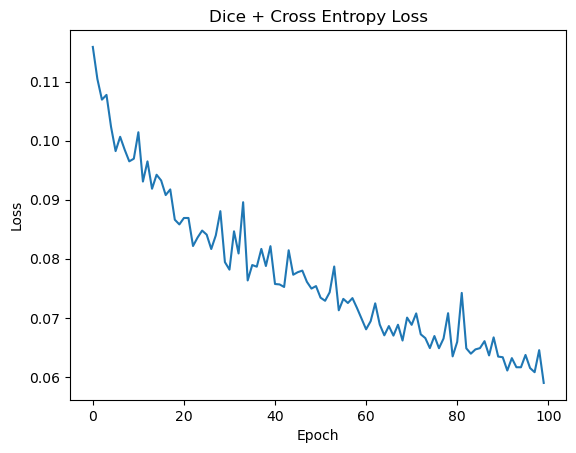

In [159]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [160]:
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

def extract_digits(string):
    digits = re.findall(r'\d{6}', string)
    if digits:
        first_part = digits[0][:4]
        second_part = digits[0][-2:]
        return first_part, second_part
    else:
        return None, None
    
def extract_same_first_elements(lst):
    result = []
    seen = set()
    for sub_list in lst:
        first_element = sub_list[0]
        if first_element not in seen:
            same_first_elements = [x for x in lst if x[0] == first_element]
            result.append(same_first_elements)
            seen.add(first_element)
    return result

In [161]:
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

test_img_path = 'data/MedSAMDemo_2D/test/images'
test_gt_path = 'data/MedSAMDemo_2D/test/labels'
test_names = sorted(os.listdir(test_img_path))

import re
    
splited_names = []
for name in test_names : 
    splited_names.append(extract_digits(name))

same_first_elements = extract_same_first_elements(splited_names)

In [162]:
# print('전체 묶음 개수 : ', len(same_first_elements))

'''image index 리스트 정렬'''
sum = 0
idx_list = []
idx_list.append(0)
count_list = []
count_list.append(0)
for a in same_first_elements : 
    # print(len(a))
    sum = sum + len(a)
    count_list.append(sum-1)
    
    idx_list.append(sum-1)
    idx_list.append(sum)
    # print(idx_list[-2:])
    if a == same_first_elements[-1] : 
        idx_list.append(sum-1)


# print(idx_list)
idx_list = [idx_list[i:i+2] for i in range(0, len(idx_list), 2)]
# print('총 개수 : ', sum)
print('idx_list : ', idx_list)
print('count_list : ', count_list)

idx_list :  [[0, 15], [16, 26], [27, 32], [33, 42], [43, 47], [48, 67], [68, 76], [77, 90], [91, 91], [92, 100], [101, 100]]
count_list :  [0, 15, 26, 32, 42, 47, 67, 76, 90, 91, 100]


In [171]:

'''
original SAM 모델추론. 
첫 데이터의 bbox 는 gt_data에서 bbox를 random 하게 얻기 . 
'''
global ori_sam_seg
global sam_box
def original_inference(img_idx, image_data, test_gt_path = test_gt_path) : 
    global ori_sam_seg
    global sam_box
    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))

    if img_idx in count_list : 
        bbox_raw = get_bbox_from_mask(gt_data)
    else : 
        bbox_raw = get_bbox_from_mask(ori_sam_seg)

    sam_box = bbox_raw
    # preprocess: cut-off and max-min normalization
    lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
    image_data_pre = np.clip(image_data, lower_bound, upper_bound)
    image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
    image_data_pre[image_data==0] = 0
    image_data_pre = np.uint8(image_data_pre)
    H, W, _ = image_data_pre.shape

    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(image_data_pre)
    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
    ori_sam_seg = ori_sam_seg.reshape((256, 256)).astype(np.uint8)
    return ori_sam_seg, image_data_pre

In [172]:
'''
MedSAM으로 inference 수행하기 
'''

global medsam_seg
global medsam_box
def medsam_inference(image_data_pre, img_idx, test_gt_path = test_gt_path) : 
    global medsam_seg
    global medsam_box
    # predict the segmentation mask using the fine-tuned model
    # resize image to 3*1024*1024
    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    resize_img = sam_transform.apply_image(image_data_pre)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

    #get bbox
    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))

    if img_idx in count_list : 
        bbox_raw = get_bbox_from_mask(gt_data)
    else : 
        bbox_raw = get_bbox_from_mask(medsam_seg)

    medsam_box = bbox_raw
    with torch.no_grad():
        # pre-compute the image embedding
        ts_img_embedding = sam_model.image_encoder(input_image)
        # convert box to 1024x1024 grid
        bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
        # print(f'{bbox_raw=} -> {bbox=}')
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    return medsam_seg
    # print(medsam_seg.shape)

In [173]:
'''
image idx 선택 후 preprocess
'''

SAM_seg_result = []
MEDSAM_seg_result = []

for start, end in idx_list : 
    for i in range(start, end+1) :       
        img_idx = i
        image_data = io.imread(join(test_img_path, test_names[img_idx]))

        if image_data.shape[-1]>3 and len(image_data.shape)==3:
            image_data = image_data[:,:,:3]
        if len(image_data.shape)==2:
            image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
        
        ori_sam_seg, image_data_pre = original_inference(img_idx, image_data)
        medsam_seg = medsam_inference(image_data_pre, img_idx)

        gt_data = io.imread(join(test_gt_path, test_names[img_idx]))
        ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
        medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
        # print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

        SAM_seg_result.append(ori_sam_dsc)
        MEDSAM_seg_result.append(medsam_dsc)

        

In [176]:
compete_result = (np.array(SAM_seg_result) - np.array(MEDSAM_seg_result)) > 0 
counts = np.sum(compete_result== True)
print('count : ', counts)
index = np.where(compete_result == True)

print(index)
for i in index[0] : 
    print('SAM : ',  SAM_seg_result[i], ', MEDSAM : ', MEDSAM_seg_result[i] )


SAM_avg = np.sum(SAM_seg_result)/len(SAM_seg_result)
Med_avg = np.sum(MEDSAM_seg_result)/len(MEDSAM_seg_result)
print('SAM average : ', SAM_avg, ', MedSAM average : ', Med_avg)


count :  11
(array([ 2, 17, 30, 31, 34, 35, 36, 37, 38, 43, 44]),)
SAM :  0.43097151205259315 , MEDSAM :  0.3164983164983165
SAM :  0.09407665505226481 , MEDSAM :  0.0
SAM :  0.024313153415998056 , MEDSAM :  0.0
SAM :  0.07303689687795648 , MEDSAM :  0.0
SAM :  0.0013360053440213762 , MEDSAM :  0.0
SAM :  0.05660377358490566 , MEDSAM :  0.0
SAM :  0.07970170123514332 , MEDSAM :  0.0
SAM :  0.17648912700913963 , MEDSAM :  0.0
SAM :  0.07382920110192838 , MEDSAM :  0.0
SAM :  0.24542772861356932 , MEDSAM :  0.0
SAM :  0.00772573635924674 , MEDSAM :  0.0
SAM average :  0.23993523141433584 , MedSAM average :  0.6608319674249014


In [169]:
count_list

[0, 15, 26, 32, 42, 47, 67, 76, 90, 91, 100]

In [177]:
'''
하나씩 선택하는 함수
'''

global ori_sam_dsc
global medsam_dsc
def select_inference(index_num) : 
    global ori_sam_seg, medsam_seg    
    global ori_sam_dsc, medsam_dsc
    img_idx = index_num
    image_data = io.imread(join(test_img_path, test_names[img_idx]))

    if image_data.shape[-1]>3 and len(image_data.shape)==3:
        image_data = image_data[:,:,:3]
    if len(image_data.shape)==2:
        image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
            
    ori_sam_seg, image_data_pre = original_inference(img_idx, image_data)
    medsam_seg = medsam_inference(image_data_pre, img_idx)

    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))
    ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
    medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
    print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

# SAM_seg_result.append(ori_sam_dsc)
# MEDSAM_seg_result.append(medsam_dsc)

In [178]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    


In [179]:
inversed_list = index[0]
print(inversed_list)

# select_inference(inversed_list[3])


[ 2 17 30 31 34 35 36 37 38 43 44]
Original SAM DSC: 0.0000 MedSAM DSC: 0.8850


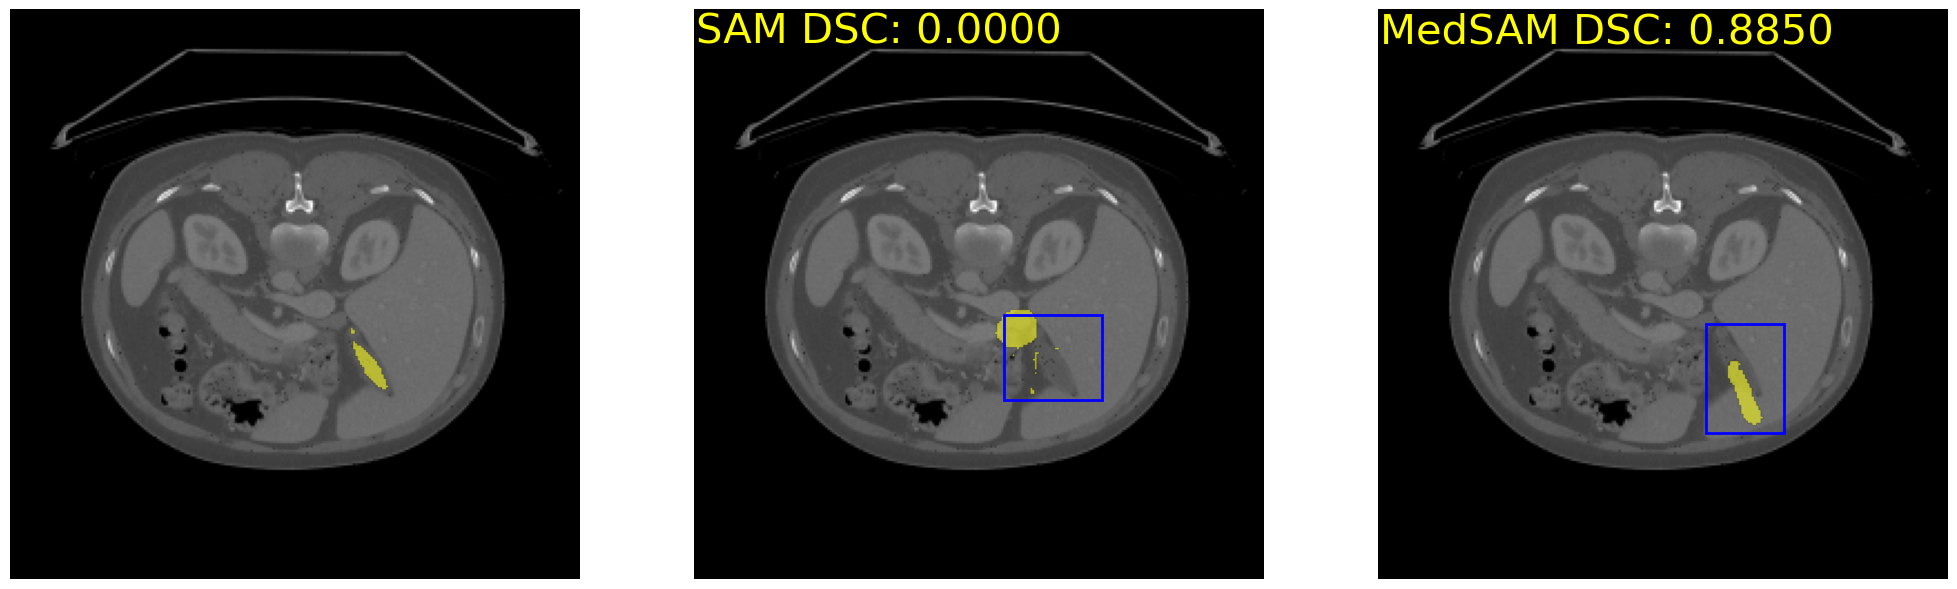

In [180]:

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(sam_box, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(medsam_box, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

여기서부터는 compare를 위한 부분

In [181]:

'''
original SAM 모델추론. all boxes from gt
'''
# global ori_sam_seg
# global sam_box
def original_inference(img_idx, image_data, test_gt_path = test_gt_path) : 
    global ori_sam_seg
    global sam_box
    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))

    bbox_raw = get_bbox_from_mask(gt_data)

    sam_box = bbox_raw
    # preprocess: cut-off and max-min normalization
    lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
    image_data_pre = np.clip(image_data, lower_bound, upper_bound)
    image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
    image_data_pre[image_data==0] = 0
    image_data_pre = np.uint8(image_data_pre)
    H, W, _ = image_data_pre.shape

    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(image_data_pre)
    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
    ori_sam_seg = ori_sam_seg.reshape((256, 256)).astype(np.uint8)
    return ori_sam_seg, image_data_pre

def medsam_inference(image_data_pre, img_idx, test_gt_path = test_gt_path) : 
    global medsam_seg
    global medsam_box
    # predict the segmentation mask using the fine-tuned model
    # resize image to 3*1024*1024
    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    resize_img = sam_transform.apply_image(image_data_pre)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

    #get bbox
    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))

    bbox_raw = get_bbox_from_mask(gt_data)


    medsam_box = bbox_raw
    with torch.no_grad():
        # pre-compute the image embedding
        ts_img_embedding = sam_model.image_encoder(input_image)
        # convert box to 1024x1024 grid
        bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
        # print(f'{bbox_raw=} -> {bbox=}')
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    return medsam_seg



from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

test_img_path = 'data/MedSAMDemo_2D/test/images'
test_gt_path = 'data/MedSAMDemo_2D/test/labels'
test_names = sorted(os.listdir(test_img_path))

import re
    
splited_names = []
for name in test_names : 
    splited_names.append(extract_digits(name))

same_first_elements = extract_same_first_elements(splited_names)

# print('전체 묶음 개수 : ', len(same_first_elements))

'''image index 리스트 정렬'''
sum = 0
idx_list = []
idx_list.append(0)
count_list = []
count_list.append(0)
for a in same_first_elements : 
    # print(len(a))
    sum = sum + len(a)
    count_list.append(sum-1)
    
    idx_list.append(sum-1)
    idx_list.append(sum)
    # print(idx_list[-2:])
    if a == same_first_elements[-1] : 
        idx_list.append(sum-1)


# print(idx_list)
idx_list = [idx_list[i:i+2] for i in range(0, len(idx_list), 2)]
# print('총 개수 : ', sum)
print('idx_list : ', idx_list)
print('count_list : ', count_list)

SAM_seg_result = []
MEDSAM_seg_result = []

for start, end in idx_list : 
    for i in range(start, end+1) :       
        img_idx = i
        image_data = io.imread(join(test_img_path, test_names[img_idx]))

        if image_data.shape[-1]>3 and len(image_data.shape)==3:
            image_data = image_data[:,:,:3]
        if len(image_data.shape)==2:
            image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
        
        ori_sam_seg, image_data_pre = original_inference(img_idx, image_data)
        medsam_seg = medsam_inference(image_data_pre, img_idx)

        gt_data = io.imread(join(test_gt_path, test_names[img_idx]))
        ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
        medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
        # print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

        SAM_seg_result.append(ori_sam_dsc)
        MEDSAM_seg_result.append(medsam_dsc)

compete_result = (np.array(SAM_seg_result) - np.array(MEDSAM_seg_result)) > 0 
counts = np.sum(compete_result== True)
print('count : ', counts)
index = np.where(compete_result == True)

print(index)
for i in index[0] : 
    print('SAM : ',  SAM_seg_result[i], ', MEDSAM : ', MEDSAM_seg_result[i] )

SAM_avg = np.sum(SAM_seg_result)/len(SAM_seg_result)
Med_avg = np.sum(MEDSAM_seg_result)/len(MEDSAM_seg_result)
print('SAM average : ', SAM_avg, ', MedSAM average : ', Med_avg)


idx_list :  [[0, 15], [16, 26], [27, 32], [33, 42], [43, 47], [48, 67], [68, 76], [77, 90], [91, 91], [92, 100], [101, 100]]
count_list :  [0, 15, 26, 32, 42, 47, 67, 76, 90, 91, 100]
count :  4
(array([14, 38, 82, 90]),)
SAM :  0.8693957115009746 , MEDSAM :  0.855036855036855
SAM :  0.8083441981747066 , MEDSAM :  0.7932011331444759
SAM :  0.9058663028649386 , MEDSAM :  0.9022082018927445
SAM :  0.6222222222222222 , MEDSAM :  0.3067484662576687
SAM average :  0.6499213099392332 , MedSAM average :  0.8921760599271702


In [183]:

proposed_method  = 100-(11/101*100)
gt_method = 100-(4/101*100)
print(proposed_method)
print(gt_method)


89.10891089108911
96.03960396039604
